In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys 

NFF_PATH = '/home/wwj/Repo/playgrounds/NeuralForceField/'
ODE_PATH = '/home/wwj/Repo/projects/torchdiffeq/'

sys.path.insert(0, NFF_PATH)
sys.path.insert(0, ODE_PATH)
sys.path.insert(0, '../..')

import torch
from torch.optim import Adam
from torchdiffeq import odeint_adjoint as odeint
from torchmd.ode import ODE, NHCHAIN_ODE
from torchmd.hamiltoinians import PairPot, MLP, LennardJones, Buck, LennardJones69
from torchmd.utils import *

from nff.utils.scatter import compute_grad
from nff.nn.layers import GaussianSmearing
from ase import Atoms

import ase
from ase.neighborlist import neighbor_list
from ase.lattice.cubic import FaceCenteredCubic
from ase.geometry import wrap_positions

from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units

_ColormakerRegistry()

In [2]:
# ASE Unit initialization

In [3]:
# Argon 

# epsilon
# epsilon = 1.65 * 10**(-21) * 6.241509*10**18

# rho = (18/1.784)* units.mol * ( 1 /10**27 )
# L = (4/rho) ** (1/3)

# DEVICE = 0
# CUTOFF = 12.5
# size = 4
# atoms = FaceCenteredCubic(directions=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
#                           symbol='Ar',
#                           size=(size, size, size),
#                           latticeconstant= L,
#                           pbc=True)
# #NATOMS = atoms.get_number_of_atoms()
# N = atoms.get_number_of_atoms()

# mass = atoms.get_masses()

In [4]:
DEVICE = 0
CUTOFF = 3.0
size = 4

L = (4/0.844)**(1/3)

atoms = FaceCenteredCubic(directions=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
                          symbol='H',
                          size=(size, size, size),
                          latticeconstant= L,
                          pbc=True)
#NATOMS = atoms.get_number_of_atoms()
N = atoms.get_number_of_atoms()

mass = atoms.get_masses()

In [254]:
atoms.get_number_of_atoms()/ atoms.get_volume()

0.8439999999999999

In [5]:
mass 


array([1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008,
       1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008,
       1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008,
       1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008,
       1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008,
       1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008,
       1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008,
       1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008,
       1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008,
       1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008,
       1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008,
       1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008,
       1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008,
       1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008, 1.008,
       1.008, 1.008,

In [255]:
show_ase(atoms)

NGLWidget()

In [256]:
# Define a Hamiltonian: Pairwise LJ potentials 

In [257]:
lj_params = {'epsilon': 1.0, 
             'sigma': 1.0}

model = PairPot(LennardJones, lj_params,
                cell=torch.Tensor(atoms.get_cell()).diag(), 
                device=DEVICE,
                cutoff=CUTOFF,
                ).to(DEVICE)


In [266]:
p.reshape(-1, 3).pow(2).sum(-1).mean() / 3

tensor(1.2553)

# intialize a vectorized tensor as initial conditions for the solver

In [267]:
T= 1.8

# declare position and momentum as initial values
xyz = torch.Tensor(atoms.get_positions())
xyz = xyz.reshape(-1)

# generate random velocity 
MaxwellBoltzmannDistribution(atoms, T)

p = torch.Tensor( atoms.get_velocities().reshape(-1)) #.to(DEVICE)
p_v = torch.Tensor([0.0] * 5)
pq = torch.cat((p, xyz, p_v)).to(DEVICE)
pq.requires_grad= True

# Integrating EOM

In [268]:
%%time
f_x = NHCHAIN_ODE(model, 
        mass, 
        Q=10.0, 
        T=T,
        num_chains=5, 
        device=DEVICE).to(DEVICE)

# update frequency 
interval = 20
traj = []
for i in range(30):
    t = torch.Tensor([0.002 * i for i in range(interval)]).to(DEVICE)
    pq = odeint(f_x, pq, t, method='rk4')
    traj.append(pq.detach())
    pq = pq.detach()[-1]
    
    # wrap coordinates 
    xyz = pq[N*3: N*6].reshape(-1, 3).detach().cpu().numpy()
    xyz = torch.Tensor( wrap_positions( xyz, atoms.get_cell()) ).reshape(-1)
    pq[N*3: N*6] = xyz.to(DEVICE)
    
    #traj.append(pq.detach())

traj = torch.cat(traj)

CPU times: user 35.2 s, sys: 34.3 s, total: 1min 9s
Wall time: 8.64 s


# Dump and visualize movies

In [269]:
dump_mov(traj[:, :N*6 ], atoms, "./metadta/LJ_1.pdb")
view = show_pdb("./metadta/LJ_1.pdb")

In [270]:
view

NGLWidget(max_frame=599)

In [271]:
class Observable(torch.nn.Module):
    def __init__(self):
        super(Observable, self).__init__()
    

class rdf(Observable):
    def __init__(self, atoms, nbins, device, cutoff):
        super(rdf, self).__init__()
        PI = np.pi
        self.bins = torch.linspace(0, cutoff, nbins + 1).to(device)
        
        self.smear = GaussianSmearing(
                    start=0.0,
                    stop=self.bins[-1],
                    n_gaussians=nbins,
                    trainable=False
                ).to(device)
        self.volume = atoms.get_volume()
        self.cutoff = cutoff
        self.cell = torch.Tensor( atoms.get_cell()).diag().to(device)
        self.vol_bins = 4 * PI /3*(self.bins[1:]**3 - self.bins[:-1]**3).to(device)
        self.device = device 
        self.natoms = atoms.get_number_of_atoms()
        self.nbins = nbins
        
        # scale cutoff to adjust smearing error of the last bin 
        self.cutoff += (self.bins[1] - self.bins[0]) * 2
        
        
    def forward(self, xyz):
        
        if len(list( xyz.shape )) != 3 and xyz.shape[-1] != 3:
            # Get positions 
            xyz = xyz[:, self.natoms * 3:].reshape(-1, self.natoms, 3)

        # Compute RDF         
        dis_mat = xyz[:, None, :, :] - xyz[:, :, None, :]
        offsets = -dis_mat.ge(0.5 * self.cell).to(torch.float).to(self.device) + \
                        dis_mat.lt(-0.5 * self.cell).to(torch.float).to(self.device)
        dis_mat = dis_mat + offsets * self.cell

        dis_sq = dis_mat.pow(2).sum(-1)
        mask = (dis_sq < (self.cutoff) ** 2) & (dis_sq != 0)
        
        print(mask.shape)
        # comput
        pair_dis = dis_sq[mask].sqrt()

        N_count = mask.sum()
        count = self.smear(pair_dis.squeeze()[..., None]).sum(0)
        
        print(pair_dis.shape)
        norm = count.sum() # normalization factor for histogram 
        count = count / norm # normalize to get probability distributions 
        rdf =  count / (2 * self.vol_bins / ( (2 * self.cutoff) ** 3)) # interactions are considered twice 
        
        return self.bins, rdf 

In [276]:
obs = rdf(atoms, 35, 0, 3.0)

In [277]:
traj = mdtraj.load_pdb("./metadta/LJ_1.pdb")
q = torch.Tensor(traj.xyz[500:][::2]).to(DEVICE) * 10.0
bins, g1 = obs(q)

torch.Size([50, 256, 256])
torch.Size([1439768])


In [278]:
# traj = mdtraj.load_pdb("./metadta/LJ_1.pdb")
# q = torch.Tensor(traj.xyz[500:][::2]).to(DEVICE) * 10.0
# bins, g2 = obs(q)

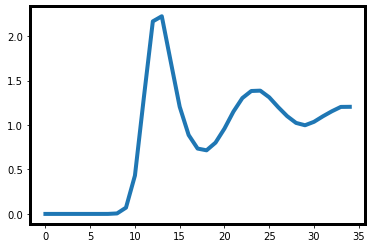

In [279]:
#plt.plot(g2.detach().cpu().numpy())
plt.plot(g1.detach().cpu().numpy())

In [184]:
def make_ase_traj(movie, ref_atoms):
    
    Natoms = ref_atoms.get_number_of_atoms()
    
    if movie.shape[-1] != Natoms * 3 * 2:
        raise ValueError("Natom does not much the reference atoms object")
    
    # strip to get xyz 
    movie = movie[:, Natoms*3:].reshape(-1, Natoms, 3).detach().cpu().numpy()
    
    atoms_list = []
    for frame in movie:
        sys = Atoms(ref_atoms.get_atomic_numbers(),
               positions=frame.reshape(-1, 3), pbc=True, cell=ref_atoms.get_cell()) 
        sys.set_positions(sys.get_positions(wrap=True))
        atoms_list.append(sys)
    
    return atoms_list 

In [ ]:
# the coordinates are not wrapped 